In [1]:
import numpy,pandas

In [3]:
test1=numpy.load('./Pylon/data1.npy')
test2=numpy.load('./Pylon/data2.npy')
test3=numpy.load('./Pylon/data3.npy')
test=numpy.concatenate((test1,test2,test3))

In [57]:
acc=pandas.read_csv('Pylon/accepted.csv',header=[0,1,2,3],index_col=0)
exc=pandas.read_csv('Pylon/excluded.csv',header=[0,1,2,3],index_col=0)
data=numpy.concatenate((acc.values,exc.values))[:3000,:]

In [58]:
print(acc.shape,data.shape)

(1392, 13) (3000, 13)


In [59]:
lenth=data.shape[0];lenth

3000

In [60]:
normalize=numpy.linalg.inv(numpy.diag([60,1e3,2e3,6e3,2e3,2e3,2e3,1,1,3e3,3e3,1500]))

In [61]:
data[:,:-1]=data[:,:-1].dot(normalize)

In [62]:
data

array([[ 0.17597688,  0.99037586,  0.58978462, ..., -0.90874412,
         0.19598302,  1.        ],
       [ 0.80411889,  0.99196261,  0.34157178, ..., -0.70621409,
         0.52246643,  1.        ],
       [ 0.21528336,  0.37404653,  0.38910384, ..., -0.37486843,
         0.62616036,  1.        ],
       ..., 
       [ 0.90410588,  0.47547668,  0.62609546, ..., -0.82132573,
         0.73818866,  0.        ],
       [ 0.09211003,  0.838369  ,  0.64216156, ..., -0.75302015,
         0.2442311 ,  0.        ],
       [ 0.27909031,  0.28071636,  0.08477074, ..., -0.46059645,
         0.49917858,  0.        ]])

In [63]:
[max(data[:,i]) for i in range(13)]

[0.99965281555857743,
 0.99967457937608772,
 0.99999342834140459,
 0.99983595247876178,
 0.99997544401075944,
 0.99953431507382762,
 0.99963666907501636,
 0.98566412588656238,
 0.95123335909411955,
 0.99975230683800775,
 0.99928923439601569,
 0.99968458674326188,
 1.0]

In [64]:
import torch
from torch.autograd import Variable
from torch import nn
bce=nn.BCEWithLogitsLoss()
in_data=Variable(torch.FloatTensor(data[:,:-1]).cuda())
target=Variable(torch.FloatTensor(data[:,-1].reshape(lenth,1)).cuda())

In [65]:
sum(target)

Variable containing:
 1392
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [66]:
class model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.

In [152]:
model=torch.nn.Sequential(
    torch.nn.Linear(12,1000),
    torch.nn.Linear(1000,1000),
#     torch.nn.ReLU(),
    torch.nn.Linear(1000,200),
    torch.nn.Linear(200,200),
    torch.nn.ReLU(),
    torch.nn.Linear(200,10),
    torch.nn.Linear(10,1),
    torch.nn.Sigmoid()
).cuda()

In [155]:
for i in range(5000):
#     out_data=model(in_data)    
    loss=bce(model(in_data),target)
    model.zero_grad()    
    loss.backward()
    if i%100==0:print(i,loss)
    for param in model.parameters():
        param.data-=1.e-1*param.grad.data


0 Variable containing:
 0.5710
[torch.cuda.FloatTensor of size 1 (GPU 0)]

100 Variable containing:
 0.5706
[torch.cuda.FloatTensor of size 1 (GPU 0)]

200 Variable containing:
 0.5700
[torch.cuda.FloatTensor of size 1 (GPU 0)]

300 Variable containing:
 0.5695
[torch.cuda.FloatTensor of size 1 (GPU 0)]

400 Variable containing:
 0.5689
[torch.cuda.FloatTensor of size 1 (GPU 0)]

500 Variable containing:
 0.5685
[torch.cuda.FloatTensor of size 1 (GPU 0)]

600 Variable containing:
 0.5681
[torch.cuda.FloatTensor of size 1 (GPU 0)]

700 Variable containing:
 0.5677
[torch.cuda.FloatTensor of size 1 (GPU 0)]

800 Variable containing:
 0.5673
[torch.cuda.FloatTensor of size 1 (GPU 0)]

900 Variable containing:
 0.5671
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1000 Variable containing:
 0.5666
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1100 Variable containing:
 0.5667
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1200 Variable containing:
 0.5662
[torch.cuda.FloatTensor of size 1 (GPU 0)]

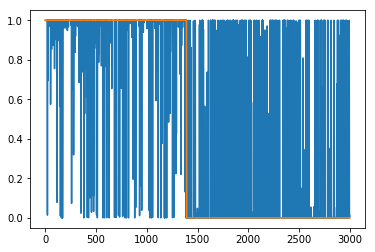

Variable containing:
 0.5608
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [156]:
import matplotlib.pyplot as plt
plt.plot(model(in_data).cpu().data.numpy().reshape(lenth,))
plt.plot(data[:,-1])
plt.show()
print(loss)

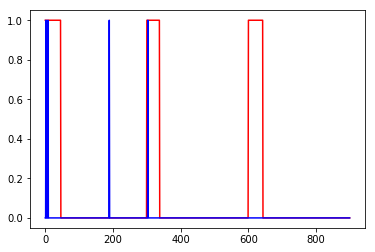

4.0


In [151]:
check_in=Variable(torch.FloatTensor(test[:,:-1]).cuda())
# check_out=Variable(torch.FloatTensor(test[:,-1].reshape(300,1)).cuda())
check_out=model(check_in).cpu().data.numpy().reshape(900,)
plt.plot(test[:,12],c='r')
plt.plot(check_out,c='b')
plt.show()
print(sum(check_out))

In [36]:
for param in model.parameters():
    s=tuple(param.data.shape)
    print(s)
#     param.data=numpy.random.rand(s)
    torch.nn.init.normal(param.data, mean=1, std=5)

(1000, 12)
(1000,)
(200, 1000)
(200,)
(10, 200)
(10,)
(1, 10)
(1,)


In [37]:
for param in model.parameters():
    print(param.data)


 2.9805e+00  3.7903e+00  5.2261e+00  ...  -4.9122e-01 -6.0955e+00 -2.9075e+00
 1.2855e+00 -1.5228e+00  2.6467e+00  ...   8.4955e-01 -1.3732e+00  9.0106e-01
-1.2673e+00  1.5764e+01  7.5603e+00  ...   7.8941e+00 -1.3395e+00  5.2513e+00
                ...                   ⋱                   ...                
-3.6344e+00 -4.3685e+00  4.4766e+00  ...   4.9931e+00 -1.6833e+00 -5.3542e+00
-7.1493e+00 -2.7142e+00 -8.0497e+00  ...   6.9458e+00 -8.7086e-01 -1.9271e+00
 9.2492e-03  1.3577e+00 -2.3067e+00  ...   8.5594e+00 -9.7786e-01  8.0548e+00
[torch.cuda.FloatTensor of size 1000x12 (GPU 0)]


 -3.0418
  2.7590
  0.2742
   ⋮    
 -0.1287
 -1.2891
  0.1341
[torch.cuda.FloatTensor of size 1000 (GPU 0)]


-9.4912e-01  1.1541e+01  1.0526e+01  ...   4.0716e+00  4.7213e+00  6.8896e+00
-5.4988e+00  2.0778e+00  7.8817e-01  ...   7.7101e-01  9.6782e-01  9.2789e+00
-2.9738e-01 -7.1480e+00 -1.2699e+00  ...  -2.5632e+00  5.7726e-01  5.0610e+00
                ...                   ⋱                  

In [93]:
len(_)

300

In [95]:
plt.plot(_.reshape(300,))

AttributeError: 'int' object has no attribute 'reshape'

In [25]:
for param in model.parameters():
    print(param.grad.data)


-8.9646e-10 -3.1003e-09 -2.2022e-09  ...   7.8005e-10 -3.5961e-09  3.8002e-09
-1.6604e-08 -5.7421e-08 -4.0788e-08  ...   1.4448e-08 -6.6604e-08  7.0385e-08
 6.5942e-08  2.2805e-07  1.6199e-07  ...  -5.7379e-08  2.6452e-07 -2.7954e-07
                ...                   ⋱                   ...                
-3.8279e-08 -1.3238e-07 -9.4034e-08  ...   3.3308e-08 -1.5355e-07  1.6227e-07
 3.4063e-08  1.1780e-07  8.3678e-08  ...  -2.9639e-08  1.3664e-07 -1.4440e-07
 8.3670e-08  2.8937e-07  2.0554e-07  ...  -7.2807e-08  3.3564e-07 -3.5470e-07
[torch.cuda.FloatTensor of size 1000x12 (GPU 0)]


1.00000e-07 *
 -0.0292
 -0.5411
  2.1491
    ⋮   
 -1.2475
  1.1101
  2.7269
[torch.cuda.FloatTensor of size 1000 (GPU 0)]


1.00000e-06 *
-0.0061  0.2468 -0.9461  ...   0.5562 -0.4848 -1.2250
[torch.cuda.FloatTensor of size 1x1000 (GPU 0)]


1.00000e-07 *
  3.1097
[torch.cuda.FloatTensor of size 1 (GPU 0)]

